# MNIST classification (digits recognition) using neural networks
      In this notebook we will look into the neural network for multiclass classification and also tuning some of the hyper parameters needed, also using data augmentation using torchvision to improve the accuracy. 

In [1]:
# Importing the required libraries
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import multiprocessing
from torch.utils.data import Dataset
import tqdm as tqdm
from torchvision import transforms
from torch.nn.functional import one_hot
from keras.datasets import mnist

In [2]:
# Now lets build a neural network... since we are going to use pytorch on GPU lets setup device agonistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Importing the MNIST dataset
(X_train123,y_train),(X_test123,y_test) = mnist.load_data()
X_train = X_train123/255
X_test = X_test123/255

In [4]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

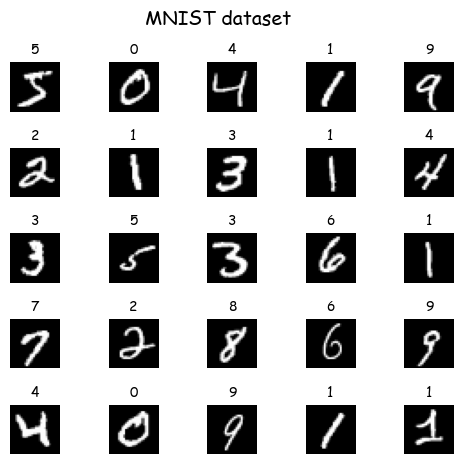

In [5]:
# Visualizing the datasets
font = {'family': 'Comic Sans MS',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }
fig, axes = plt.subplots(5,5, figsize=(5,5))
fig.tight_layout(pad=0.5,rect=[0, 0.03, 1, 0.9]) 
for i,ax in enumerate(axes.flat):
    X_clus_cen = X_train[i]
    ax.imshow(X_clus_cen, cmap='gray')
    ax.set_axis_off()
    ax.set_title(y_train[i],font = "Comic Sans MS")
fig.suptitle("MNIST dataset",fontsize=14,font = "Comic Sans MS")
plt.show()

In [6]:
# reshaping the train matrix such that it could be easily fed into the neural netword we are gonna build
train_dig = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
train_dig.shape , train_dig[:5]

((60000, 784),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [7]:
# A similar process to the test dataset
test_dig = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
test_dig.shape

(10000, 784)

In [8]:
# Converting the datasets to tensor
train_dig = torch.from_numpy(train_dig).type(torch.float32)
train_lab = torch.from_numpy(y_train).type(torch.LongTensor)
test_dig = torch.from_numpy(test_dig).type(torch.float32)
test_lab = torch.from_numpy(y_test).type(torch.LongTensor)

### Constructing a base model to train and check

In [9]:
# Constructing a model
class baseNeuralNetworkV0(nn.Module):
    def __init__(self,):
        super().__init__()
        self.NeuralNetorkSeq = nn.Sequential(
            nn.Linear(in_features=784,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=10))
        
    def forward(self,x):
        return self.NeuralNetorkSeq(x)


In [10]:
def accuracy_function(y_pred,y_true):
    correct = torch.eq(y_pred,y_true).sum().item()
    accuracy = (correct / len(y_true))*100
    return accuracy

### Using the dataloader in PyTorch to run mini-batch-gradient-descent scheme

In [11]:
# Building a dataloader with pytorch useful for mini-batch...
class Mydataset(Dataset):
    def __init__(self,data,labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index],self.labels[index]

In [12]:
train_dataset = Mydataset(train_dig,train_lab)
train_dataloader = DataLoader(train_dataset,batch_size=100,shuffle=True)
test_dataset = Mydataset(test_dig,test_lab)
test_dataloader = DataLoader(test_dataset,batch_size=100,shuffle=False)

In [13]:
# Running the same model defined above with the mini-batches
Model_1 = baseNeuralNetworkV0().to(device)

# Setup loss function
loss_fn1 = nn.CrossEntropyLoss()

# Setup optimizer
#optimizer1 = torch.optim.Adam(params=Model_1.parameters(),lr=0.0001)
optimizer1 = torch.optim.SGD(params=Model_1.parameters(),lr=0.01,weight_decay=1e-6,momentum=0.95)

In [14]:
# Training loop
# running the training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs=15
# Changing the datasets to target device
best_accuracy = 0
train_loss_chk = np.array([])
for epoch in range(1,epochs+1):
    correct_train,train_loss = 0,0
    for train_nn,label_nn in train_dataloader:
        train_nn = train_nn.to(device)
        label_nn = label_nn.to(device)
        # Setting the model in train mode
        Model_1.train()

        # Getting the output and prediction
        y_logits = Model_1(train_nn)
        soft = nn.Softmax(dim=1)
        y_soft = soft(y_logits)
        y_pred = torch.argmax(y_soft,axis=1)

        # Finding the loss 
        loss = loss_fn1(y_logits,label_nn)
        train_loss += loss.item()
        #train_loss_chk = np.append(train_loss_chk,loss.detach().cpu().numpy())
        #acc = accuracy_function(y_pred=y_pred,y_true=label_nn)
        correct_train += torch.eq(y_pred,label_nn).sum().item()

        #optimizer to zerograd
        optimizer1.zero_grad()

        # Backtracking
        loss.backward()

        # Gradient descent
        optimizer1.step()

    #Evaluating step
    Model_1.eval()
    train_loss/=len(train_dataloader.dataset)
    train_loss_chk = np.append(train_loss_chk,train_loss)
    acc = 100.*(correct_train/len(train_dataloader.dataset))
    #Evaluvating test loss too
    with torch.inference_mode():
        correct_test,loss_test = 0,0
        for test_nn,tlabel_nn in test_dataloader:
            test_nn = test_nn.to(device)
            tlabel_nn = tlabel_nn.to(device)
            test_logits = Model_1(test_nn).squeeze()
            test_pred = torch.argmax(soft(test_logits),axis=1)
            correct_test += torch.eq(test_pred,tlabel_nn).sum().item()
            loss_test += loss_fn1(test_logits,tlabel_nn)
        loss_test/=len(test_dataloader.dataset)
        acc_test = 100.*(correct_test/len(test_dataloader.dataset))
        # Check convergence...
    if acc_test > best_accuracy:
        best_accuracy = acc_test
        best_epoch = epoch

        # Save best weights
        torch.save(Model_1.state_dict(), "best_model.pt") 
    if epoch%1==0:
        print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f}")
    #if epoch>5:
        #loss_conv = train_loss_chk[-2] - train_loss_chk[-1]
        #if loss_conv <0.00004:
            #print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f} | broken!!!")
            #break   

print("\nBEST TEST ACCURACY: ", best_accuracy, " in epoch ", best_epoch)


Epoch: 1 | Loss: 0.005032 | Acc: 86.393333 | Test loss: 0.001923 | Test acc: 94.300000
Epoch: 2 | Loss: 0.001527 | Acc: 95.521667 | Test loss: 0.001194 | Test acc: 96.280000
Epoch: 3 | Loss: 0.001006 | Acc: 97.065000 | Test loss: 0.000950 | Test acc: 97.070000
Epoch: 4 | Loss: 0.000725 | Acc: 97.856667 | Test loss: 0.001022 | Test acc: 96.930000
Epoch: 5 | Loss: 0.000564 | Acc: 98.291667 | Test loss: 0.000721 | Test acc: 97.790000
Epoch: 6 | Loss: 0.000448 | Acc: 98.663333 | Test loss: 0.000691 | Test acc: 97.810000
Epoch: 7 | Loss: 0.000348 | Acc: 99.010000 | Test loss: 0.000662 | Test acc: 97.980000
Epoch: 8 | Loss: 0.000265 | Acc: 99.268333 | Test loss: 0.000632 | Test acc: 98.030000
Epoch: 9 | Loss: 0.000213 | Acc: 99.416667 | Test loss: 0.000693 | Test acc: 97.890000
Epoch: 10 | Loss: 0.000169 | Acc: 99.556667 | Test loss: 0.000618 | Test acc: 97.990000
Epoch: 11 | Loss: 0.000139 | Acc: 99.638333 | Test loss: 0.000630 | Test acc: 98.090000
Epoch: 12 | Loss: 0.000102 | Acc: 99.7883

### Now lets took into Hyperparameter tuning...
    Firstly we will be tuning the neurons per layer (However the number of hidden layers is fixed to be 2).

In [15]:
# Now lets so the hyperparameters tuning...
# Constructing a new model to use for hyper parameters (We will keep the same number of neurons for both layers)

class baseNeuralNetworkV1(nn.Module):
    def __init__(self,layer_neuron):
        super().__init__()
        self.layer_neuron = layer_neuron
        self.NeuralNetorkSeq = nn.Sequential(
            nn.Linear(in_features=784,out_features=self.layer_neuron),
            nn.ReLU(),
            nn.Linear(in_features=self.layer_neuron,out_features=self.layer_neuron),
            nn.ReLU(),
            nn.Linear(in_features=self.layer_neuron,out_features=10))
        
    def forward(self,x):
        return self.NeuralNetorkSeq(x)


In [16]:
first_layer_input = torch.tensor([128,256,400,512,750,1024])
#second_layer_input = torch.arange(20,110,20)

epochs=25
# Changing the datasets to target device
train_nn = train_dig.to(device)
label_nn = train_lab.to(device)
test_nn = test_dig.to(device)
tlabel_nn = test_lab.to(device)

layer_chk1 = np.array([])
layer_chk2 = np.array([])
test_losses = np.array([])
train_losses = np.array([])
test_accuracy = np.array([])
train_accuracy = np.array([])
i=0
for layer1_ in first_layer_input:
    for layer2_ in range(1):
        torch.manual_seed(42)
        Model_new = baseNeuralNetworkV1(layer1_).to(device)
        
        # Setup loss function
        loss_fn_new = nn.CrossEntropyLoss()

        # Setup optimizer
        optimizer_new = torch.optim.SGD(params=Model_new.parameters(),lr=0.01,weight_decay=1e-6,momentum=0.95)

        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        epochs=25
        # Changing the datasets to target device
        best_accuracy = 0
        train_loss_chk = np.array([])
        for epoch in range(1,epochs+1):
            correct_train,train_loss = 0,0
            for train_nn,label_nn in train_dataloader:
                train_nn = train_nn.to(device)
                label_nn = label_nn.to(device)
                # Setting the model in train mode
                Model_new.train()

                # Getting the output and prediction
                y_logits = Model_new(train_nn)
                soft = nn.Softmax(dim=1)
                y_soft = soft(y_logits)
                y_pred = torch.argmax(y_soft,axis=1)

                # Finding the loss 
                loss = loss_fn_new(y_logits,label_nn)
                train_loss += loss.item()
                #train_loss_chk = np.append(train_loss_chk,loss.detach().cpu().numpy())
                #acc = accuracy_function(y_pred=y_pred,y_true=label_nn)
                correct_train += torch.eq(y_pred,label_nn).sum().item()

                #optimizer to zerograd
                optimizer_new.zero_grad()

                # Backtracking
                loss.backward()

                # Gradient descent
                optimizer_new.step()

            #Evaluating step
            Model_new.eval()
            train_loss/=len(train_dataloader.dataset)
            train_loss_chk = np.append(train_loss_chk,train_loss)
            acc = 100.*(correct_train/len(train_dataloader.dataset))
            #Evaluvating test loss too
            with torch.inference_mode():
                correct_test,loss_test = 0,0
                for test_nn,tlabel_nn in test_dataloader:
                    test_nn = test_nn.to(device)
                    tlabel_nn = tlabel_nn.to(device)
                    test_logits = Model_new(test_nn).squeeze()
                    test_pred = torch.argmax(soft(test_logits),axis=1)
                    correct_test += torch.eq(test_pred,tlabel_nn).sum().item()
                    loss_test += loss_fn_new(test_logits,tlabel_nn)
                loss_test/=len(test_dataloader.dataset)
                acc_test = 100.*(correct_test/len(test_dataloader.dataset))
                # Check convergence...
            if acc_test > best_accuracy:
                best_accuracy = acc_test
                best_epoch = epoch

                # Save best weights
                #torch.save(Model_1.state_dict(), "best_model.pt") 
            if epoch>5:
                loss_conv = train_loss_chk[-2] - train_loss_chk[-1]
                if loss_conv <0.00004:
                    print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f} | broken!!!")
                    break
        layer_chk1 = np.append(layer_chk1,layer1_.cpu().numpy())
        #layer_chk2 = np.append(layer_chk2,layer2_.cpu().numpy())
        test_accuracy = np.append(test_accuracy,acc_test)
        train_accuracy = np.append(train_accuracy,acc)
        test_losses = np.append(test_losses,loss_test.cpu().detach().numpy())
        train_losses = np.append(train_losses,train_loss)
    i+=1
    print(f"Completed {i}/6 part")

Epoch: 11 | Loss: 0.000264 | Acc: 99.216667 | Test loss: 0.000772 | Test acc: 97.790000 | broken!!!
Completed 1/6 part
Epoch: 11 | Loss: 0.000190 | Acc: 99.440000 | Test loss: 0.000693 | Test acc: 98.020000 | broken!!!
Completed 2/6 part
Epoch: 11 | Loss: 0.000164 | Acc: 99.580000 | Test loss: 0.000661 | Test acc: 98.060000 | broken!!!
Completed 3/6 part
Epoch: 11 | Loss: 0.000140 | Acc: 99.641667 | Test loss: 0.000629 | Test acc: 98.130000 | broken!!!
Completed 4/6 part
Epoch: 11 | Loss: 0.000123 | Acc: 99.710000 | Test loss: 0.000581 | Test acc: 98.280000 | broken!!!
Completed 5/6 part
Epoch: 10 | Loss: 0.000143 | Acc: 99.661667 | Test loss: 0.000570 | Test acc: 98.270000 | broken!!!
Completed 6/6 part


In [17]:
import pandas as pd
Hyper_tuning = pd.DataFrame({'Layer1':layer_chk1,'Layer2':layer_chk1,'Train loss':train_losses,'Test losses':test_losses,'Train Acc':train_accuracy,'Test Acc':test_accuracy})
Hyper_tuning.to_csv('Hyper tuning mat for MNIST_new_neueons_SGD.csv')
Hyper_tuning

,Layer1,Layer2,Train loss,Test losses,Train Acc,Test Acc
0,128.0,128.0,0.000264,0.000772,99.216667,97.79
1,256.0,256.0,0.000190,0.000693,99.440000,98.02
2,400.0,400.0,0.000164,0.000661,99.580000,98.06
3,512.0,512.0,0.000140,0.000629,99.641667,98.13
4,750.0,750.0,0.000123,0.000581,99.710000,98.28
5,1024.0,1024.0,0.000143,0.000570,99.661667,98.27


    From this 512-512 seems as a better choise as it is easier to train and attains good accuracies...

    Next we will be tuning the learning rate of SGD...

In [18]:
class baseNeuralNetworkV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.NeuralNetorkSeq = nn.Sequential(
            nn.Linear(in_features=784,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=10))
        
    def forward(self,x):
        return self.NeuralNetorkSeq(x)

In [19]:
# Lets tune the learning rate to be fed into the SGD...
learn_rate = torch.Tensor([0.001,0.0025,0.005,0.0075,0.01,0.015,0.02,0.025,0.05])
layer_chk1 = np.array([])
layer_chk2 = np.array([])
test_losses = np.array([])
train_losses = np.array([])
test_accuracy = np.array([])
train_accuracy = np.array([])
i=0
for learn_ in learn_rate:
    Model_new = baseNeuralNetworkV2().to(device)
    # Setup loss function
    loss_fn_new = nn.CrossEntropyLoss()

    # Setup optimizer
    optimizer_new = torch.optim.SGD(params=Model_new.parameters(),lr=learn_,weight_decay=1e-6,momentum=0.95)

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    epochs=50
    # Changing the datasets to target device
    best_accuracy = 0
    train_loss_chk = np.array([])
    for epoch in range(1,epochs+1):
        correct_train,train_loss = 0,0
        for train_nn,label_nn in train_dataloader:
            train_nn = train_nn.to(device)
            label_nn = label_nn.to(device)
            # Setting the model in train mode
            Model_new.train()

            # Getting the output and prediction
            y_logits = Model_new(train_nn)
            soft = nn.Softmax(dim=1)
            y_soft = soft(y_logits)
            y_pred = torch.argmax(y_soft,axis=1)

            # Finding the loss 
            loss = loss_fn_new(y_logits,label_nn)
            train_loss += loss.item()
            #train_loss_chk = np.append(train_loss_chk,loss.detach().cpu().numpy())
            #acc = accuracy_function(y_pred=y_pred,y_true=label_nn)
            correct_train += torch.eq(y_pred,label_nn).sum().item()

            #optimizer to zerograd
            optimizer_new.zero_grad()

            # Backtracking
            loss.backward()

            # Gradient descent
            optimizer_new.step()

        #Evaluating step
        Model_new.eval()
        train_loss/=len(train_dataloader.dataset)
        train_loss_chk = np.append(train_loss_chk,train_loss)
        acc = 100.*(correct_train/len(train_dataloader.dataset))
        #Evaluvating test loss too
        with torch.inference_mode():
            correct_test,loss_test = 0,0
            for test_nn,tlabel_nn in test_dataloader:
                test_nn = test_nn.to(device)
                tlabel_nn = tlabel_nn.to(device)
                test_logits = Model_new(test_nn).squeeze()
                test_pred = torch.argmax(soft(test_logits),axis=1)
                correct_test += torch.eq(test_pred,tlabel_nn).sum().item()
                loss_test += loss_fn_new(test_logits,tlabel_nn)
            loss_test/=len(test_dataloader.dataset)
            acc_test = 100.*(correct_test/len(test_dataloader.dataset))
            # Check convergence...
        if acc_test > best_accuracy:
            best_accuracy = acc_test
            best_epoch = epoch

            # Save best weights
            #torch.save(Model_1.state_dict(), "best_model.pt") 
        if epoch>5:
            loss_conv = train_loss_chk[-2] - train_loss_chk[-1]
            if loss_conv <0.00004:
                print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f} | broken!!!")
                break
    layer_chk1 = np.append(layer_chk1,layer1_.cpu().numpy())
    #layer_chk2 = np.append(layer_chk2,layer2_.cpu().numpy())
    test_accuracy = np.append(test_accuracy,acc_test)
    train_accuracy = np.append(train_accuracy,acc)
    test_losses = np.append(test_losses,loss_test.cpu().detach().numpy())
    train_losses = np.append(train_losses,train_loss)
    i+=1
    print(f"Completed {i}/9 part")

Epoch: 24 | Loss: 0.000827 | Acc: 97.706667 | Test loss: 0.000961 | Test acc: 97.130000 | broken!!!
Completed 1/9 part
Epoch: 18 | Loss: 0.000401 | Acc: 98.928333 | Test loss: 0.000712 | Test acc: 97.860000 | broken!!!
Completed 2/9 part
Epoch: 14 | Loss: 0.000238 | Acc: 99.358333 | Test loss: 0.000669 | Test acc: 97.890000 | broken!!!
Completed 3/9 part
Epoch: 12 | Loss: 0.000161 | Acc: 99.610000 | Test loss: 0.000586 | Test acc: 98.200000 | broken!!!
Completed 4/9 part
Epoch: 11 | Loss: 0.000142 | Acc: 99.638333 | Test loss: 0.000658 | Test acc: 98.070000 | broken!!!
Completed 5/9 part
Epoch: 10 | Loss: 0.000115 | Acc: 99.698333 | Test loss: 0.000610 | Test acc: 98.230000 | broken!!!
Completed 6/9 part
Epoch: 8 | Loss: 0.000175 | Acc: 99.448333 | Test loss: 0.000614 | Test acc: 98.360000 | broken!!!
Completed 7/9 part
Epoch: 9 | Loss: 0.000099 | Acc: 99.688333 | Test loss: 0.000779 | Test acc: 97.870000 | broken!!!
Completed 8/9 part
Epoch: 8 | Loss: 0.000161 | Acc: 99.470000 | Test 

In [20]:
Hyper_tuning2 = pd.DataFrame({'Learn rate':learn_rate,'Train loss':train_losses,'Test losses':test_losses,'Train Acc':train_accuracy,'Test Acc':test_accuracy})
Hyper_tuning2.to_csv('Hyper tuning mat for MNIST_learnrate_SGD_new.csv')
Hyper_tuning2

,Learn rate,Train loss,Test losses,Train Acc,Test Acc
0,0.0010,0.000827,0.000961,97.706667,97.13
1,0.0025,0.000401,0.000712,98.928333,97.86
2,0.0050,0.000238,0.000669,99.358333,97.89
3,0.0075,0.000161,0.000586,99.610000,98.20
4,0.0100,0.000142,0.000658,99.638333,98.07
5,0.0150,0.000115,0.000610,99.698333,98.23
6,0.0200,0.000175,0.000614,99.448333,98.36
7,0.0250,0.000099,0.000779,99.688333,97.87
8,0.0500,0.000161,0.000677,99.470000,98.13


    From this we see that learn_rate=0.01,0.015,0.02 seems to be the better one... with other parameters fixed... now tuning the momentum

In [21]:
# Lets tune the momentum to be fed into the SGD...
Momentum = torch.Tensor([0.85,0.9,0.925,0.95,0.975,0.99])
layer_chk1 = np.array([])
layer_chk2 = np.array([])
test_losses = np.array([])
train_losses = np.array([])
test_accuracy = np.array([])
train_accuracy = np.array([])
i=0
for Mom_ in Momentum:
    Model_new = baseNeuralNetworkV2().to(device)
    # Setup loss function
    loss_fn_new = nn.CrossEntropyLoss()

    # Setup optimizer
    optimizer_new = torch.optim.SGD(params=Model_new.parameters(),lr=0.01,weight_decay=1e-6,momentum=Mom_)

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    epochs=50
    # Changing the datasets to target device
    best_accuracy = 0
    train_loss_chk = np.array([])
    for epoch in range(1,epochs+1):
        correct_train,train_loss = 0,0
        for train_nn,label_nn in train_dataloader:
            train_nn = train_nn.to(device)
            label_nn = label_nn.to(device)
            # Setting the model in train mode
            Model_new.train()

            # Getting the output and prediction
            y_logits = Model_new(train_nn)
            soft = nn.Softmax(dim=1)
            y_soft = soft(y_logits)
            y_pred = torch.argmax(y_soft,axis=1)

            # Finding the loss 
            loss = loss_fn_new(y_logits,label_nn)
            train_loss += loss.item()
            #train_loss_chk = np.append(train_loss_chk,loss.detach().cpu().numpy())
            #acc = accuracy_function(y_pred=y_pred,y_true=label_nn)
            correct_train += torch.eq(y_pred,label_nn).sum().item()

            #optimizer to zerograd
            optimizer_new.zero_grad()

            # Backtracking
            loss.backward()

            # Gradient descent
            optimizer_new.step()

        #Evaluating step
        Model_new.eval()
        train_loss/=len(train_dataloader.dataset)
        train_loss_chk = np.append(train_loss_chk,train_loss)
        acc = 100.*(correct_train/len(train_dataloader.dataset))
        #Evaluvating test loss too
        with torch.inference_mode():
            correct_test,loss_test = 0,0
            for test_nn,tlabel_nn in test_dataloader:
                test_nn = test_nn.to(device)
                tlabel_nn = tlabel_nn.to(device)
                test_logits = Model_new(test_nn).squeeze()
                test_pred = torch.argmax(soft(test_logits),axis=1)
                correct_test += torch.eq(test_pred,tlabel_nn).sum().item()
                loss_test += loss_fn_new(test_logits,tlabel_nn)
            loss_test/=len(test_dataloader.dataset)
            acc_test = 100.*(correct_test/len(test_dataloader.dataset))
            # Check convergence...
        if acc_test > best_accuracy:
            best_accuracy = acc_test
            best_epoch = epoch

            # Save best weights
            #torch.save(Model_1.state_dict(), "best_model.pt") 
        if epoch>5:
            loss_conv = train_loss_chk[-2] - train_loss_chk[-1]
            if loss_conv <0.00004:
                print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f} | broken!!!")
                break
    layer_chk1 = np.append(layer_chk1,layer1_.cpu().numpy())
    #layer_chk2 = np.append(layer_chk2,layer2_.cpu().numpy())
    test_accuracy = np.append(test_accuracy,acc_test)
    train_accuracy = np.append(train_accuracy,acc)
    test_losses = np.append(test_losses,loss_test.cpu().detach().numpy())
    train_losses = np.append(train_losses,train_loss)
    i+=1
    print(f"Completed {i}/6 part")

Epoch: 16 | Loss: 0.000322 | Acc: 99.175000 | Test loss: 0.000695 | Test acc: 97.800000 | broken!!!
Completed 1/6 part
Epoch: 14 | Loss: 0.000222 | Acc: 99.451667 | Test loss: 0.000596 | Test acc: 98.090000 | broken!!!
Completed 2/6 part
Epoch: 13 | Loss: 0.000153 | Acc: 99.690000 | Test loss: 0.000630 | Test acc: 98.140000 | broken!!!
Completed 3/6 part
Epoch: 11 | Loss: 0.000147 | Acc: 99.638333 | Test loss: 0.000673 | Test acc: 97.940000 | broken!!!
Completed 4/6 part
Epoch: 10 | Loss: 0.000072 | Acc: 99.820000 | Test loss: 0.000618 | Test acc: 98.330000 | broken!!!
Completed 5/6 part
Epoch: 8 | Loss: 0.000223 | Acc: 99.248333 | Test loss: 0.000868 | Test acc: 97.860000 | broken!!!
Completed 6/6 part


In [22]:
Hyper_tuning3 = pd.DataFrame({'Momentum':Momentum,'Train loss':train_losses,'Test losses':test_losses,'Train Acc':train_accuracy,'Test Acc':test_accuracy})
Hyper_tuning3.to_csv('Hyper tuning mat for MNIST_momentum_SGD_new.csv')
Hyper_tuning3

,Momentum,Train loss,Test losses,Train Acc,Test Acc
0,0.850,0.000322,0.000695,99.175000,97.80
1,0.900,0.000222,0.000596,99.451667,98.09
2,0.925,0.000153,0.000630,99.690000,98.14
3,0.950,0.000147,0.000673,99.638333,97.94
4,0.975,0.000072,0.000618,99.820000,98.33
5,0.990,0.000223,0.000868,99.248333,97.86


    Now we will tune the batch size fed into the dataloader

In [23]:
Batch_size = np.array([50,75,100,125,150,200])
test_losses = np.array([])
train_losses = np.array([])
test_accuracy = np.array([])
train_accuracy = np.array([])
best_test_acc=np.array([])
i=0
for batch_ in Batch_size:
    train_dataset = Mydataset(train_dig,train_lab)
    train_dataloader = DataLoader(train_dataset,batch_size=int(batch_),shuffle=True)
    test_dataset = Mydataset(test_dig,test_lab)
    test_dataloader = DataLoader(test_dataset,batch_size=int(batch_),shuffle=False)

    Model_new = baseNeuralNetworkV2().to(device)
    # Setup loss function
    loss_fn_new = nn.CrossEntropyLoss()

    # Setup optimizer
    optimizer_new = torch.optim.SGD(params=Model_new.parameters(),lr=0.01,weight_decay=1e-6,momentum=0.9)

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    epochs=50
    # Changing the datasets to target device
    best_accuracy = 0
    train_loss_chk = np.array([])
    best_accuracy = 0
    for epoch in range(1,epochs+1):
        correct_train,train_loss = 0,0
        for train_nn,label_nn in train_dataloader:
            train_nn = train_nn.to(device)
            label_nn = label_nn.to(device)
            # Setting the model in train mode
            Model_new.train()

            # Getting the output and prediction
            y_logits = Model_new(train_nn)
            soft = nn.Softmax(dim=1)
            y_soft = soft(y_logits)
            y_pred = torch.argmax(y_soft,axis=1)

            # Finding the loss 
            loss = loss_fn_new(y_logits,label_nn)
            train_loss += loss.item()
            #train_loss_chk = np.append(train_loss_chk,loss.detach().cpu().numpy())
            #acc = accuracy_function(y_pred=y_pred,y_true=label_nn)
            correct_train += torch.eq(y_pred,label_nn).sum().item()

            #optimizer to zerograd
            optimizer_new.zero_grad()

            # Backtracking
            loss.backward()

            # Gradient descent
            optimizer_new.step()

        #Evaluating step
        Model_new.eval()
        train_loss/=len(train_dataloader.dataset)
        train_loss_chk = np.append(train_loss_chk,train_loss)
        acc = 100.*(correct_train/len(train_dataloader.dataset))
        #Evaluvating test loss too
        with torch.inference_mode():
            correct_test,loss_test = 0,0
            for test_nn,tlabel_nn in test_dataloader:
                test_nn = test_nn.to(device)
                tlabel_nn = tlabel_nn.to(device)
                test_logits = Model_new(test_nn).squeeze()
                test_pred = torch.argmax(soft(test_logits),axis=1)
                correct_test += torch.eq(test_pred,tlabel_nn).sum().item()
                loss_test += loss_fn_new(test_logits,tlabel_nn)
            loss_test/=len(test_dataloader.dataset)
            acc_test = 100.*(correct_test/len(test_dataloader.dataset))
            # Check convergence...
        if acc_test > best_accuracy:
            best_accuracy = acc_test
            best_epoch = epoch

            # Save best weights
            #torch.save(Model_1.state_dict(), "best_model.pt") 
        if epoch>5:
            loss_conv = train_loss_chk[-2] - train_loss_chk[-1]
            if loss_conv <0.00004:
                print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f} | Best Test acc: {best_accuracy:2f} | broken!!!")
                break
    best_test_acc = np.append(best_test_acc,best_accuracy)
    layer_chk1 = np.append(layer_chk1,layer1_.cpu().numpy())
    #layer_chk2 = np.append(layer_chk2,layer2_.cpu().numpy())
    test_accuracy = np.append(test_accuracy,acc_test)
    train_accuracy = np.append(train_accuracy,acc)
    test_losses = np.append(test_losses,loss_test.cpu().detach().numpy())
    train_losses = np.append(train_losses,train_loss)
    i+=1
    print(f"Completed {i}/6 part")

Epoch: 14 | Loss: 0.000118 | Acc: 99.898333 | Test loss: 0.001251 | Test acc: 98.150000 | Best Test acc: 98.150000 | broken!!!
Completed 1/6 part
Epoch: 13 | Loss: 0.000204 | Acc: 99.663333 | Test loss: 0.000859 | Test acc: 97.980000 | Best Test acc: 98.130000 | broken!!!
Completed 2/6 part
Epoch: 14 | Loss: 0.000225 | Acc: 99.415000 | Test loss: 0.000638 | Test acc: 97.980000 | Best Test acc: 98.020000 | broken!!!
Completed 3/6 part
Epoch: 14 | Loss: 0.000243 | Acc: 99.188333 | Test loss: 0.000506 | Test acc: 97.950000 | Best Test acc: 97.950000 | broken!!!
Completed 4/6 part
Epoch: 13 | Loss: 0.000288 | Acc: 98.840000 | Test loss: 0.000467 | Test acc: 97.820000 | Best Test acc: 97.820000 | broken!!!
Completed 5/6 part
Epoch: 13 | Loss: 0.000319 | Acc: 98.165000 | Test loss: 0.000417 | Test acc: 97.460000 | Best Test acc: 97.460000 | broken!!!
Completed 6/6 part


In [24]:
Hyper_tuning3 = pd.DataFrame({'Batch size':Batch_size,'Train loss':train_losses,'Test losses':test_losses,'Train Acc':train_accuracy,'Test Acc':test_accuracy,'Best Test Acc':best_test_acc})
Hyper_tuning3.to_csv('Hyper tuning mat for MNIST_batchsize_Adam.csv')
Hyper_tuning3

,Batch size,Train loss,Test losses,Train Acc,Test Acc,Best Test Acc
0,50,0.000118,0.001251,99.898333,98.15,98.15
1,75,0.000204,0.000859,99.663333,97.98,98.13
2,100,0.000225,0.000638,99.415000,97.98,98.02
3,125,0.000243,0.000506,99.188333,97.95,97.95
4,150,0.000288,0.000467,98.840000,97.82,97.82
5,200,0.000319,0.000417,98.165000,97.46,97.46


As we can see data augmentation increases the accuracy of the model. Makes it more robust...

### Final Neural Network architecture...
*  Without Data Augmentation
*  With Data Augmentation

In [25]:
# Lets now do the architecture for without data augmentation

# Importing the MNIST dataset
(X_train123,y_train),(X_test123,y_test) = mnist.load_data()
X_train = X_train123/255
X_test = X_test123/255

In [26]:
# Converting the datasets to tensor
train_dig = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
test_dig = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
train_dig = torch.from_numpy(train_dig).type(torch.float32)
train_lab = torch.from_numpy(y_train).type(torch.LongTensor)
test_dig = torch.from_numpy(test_dig).type(torch.float32)
test_lab = torch.from_numpy(y_test).type(torch.LongTensor)

In [27]:
# Building a dataloader with pytorch useful for mini-batch...
class Mydataset(Dataset):
    def __init__(self,data,labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index],self.labels[index]
    
train_dataset = Mydataset(train_dig,train_lab)
train_dataloader = DataLoader(train_dataset,batch_size=75,shuffle=True)
test_dataset = Mydataset(test_dig,test_lab)
test_dataloader = DataLoader(test_dataset,batch_size=75,shuffle=False)

In [28]:
# Constructing a model
class NeuralNetworkFinal1(nn.Module):
    def __init__(self,):
        super().__init__()
        self.NeuralNetorkSeq = nn.Sequential(
            nn.Linear(in_features=784,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=10))
        
    def forward(self,x):
        return self.NeuralNetorkSeq(x)
    
Model_fin1 = NeuralNetworkFinal1().to(device)
Model_fin1

NeuralNetworkFinal1(
  (NeuralNetorkSeq): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [29]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer
optimizer = torch.optim.SGD(params=Model_fin1.parameters(),lr=0.01,weight_decay=1e-6,momentum=0.9)

# Training loop
# running the training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs=15
# Changing the datasets to target device
best_accuracy = 0
train_loss_chk = np.array([])
for epoch in range(1,epochs+1):
    correct_train,train_loss = 0,0
    for train_nn,label_nn in train_dataloader:
        train_nn = train_nn.to(device)
        label_nn = label_nn.to(device)
        # Setting the model in train mode
        Model_fin1.train()

        # Getting the output and prediction
        y_logits = Model_fin1(train_nn)
        soft = nn.Softmax(dim=1)
        y_soft = soft(y_logits)
        y_pred = torch.argmax(y_soft,axis=1)

        # Finding the loss 
        loss = loss_fn(y_logits,label_nn)
        train_loss += loss.item()
        #train_loss_chk = np.append(train_loss_chk,loss.detach().cpu().numpy())
        #acc = accuracy_function(y_pred=y_pred,y_true=label_nn)
        correct_train += torch.eq(y_pred,label_nn).sum().item()

        #optimizer to zerograd
        optimizer.zero_grad()

        # Backtracking
        loss.backward()

        # Gradient descent
        optimizer.step()

    #Evaluating step
    Model_fin1.eval()
    train_loss/=len(train_dataloader.dataset)
    train_loss_chk = np.append(train_loss_chk,train_loss)
    acc = 100.*(correct_train/len(train_dataloader.dataset))
    #Evaluvating test loss too
    with torch.inference_mode():
        correct_test,loss_test = 0,0
        for test_nn,tlabel_nn in test_dataloader:
            test_nn = test_nn.to(device)
            tlabel_nn = tlabel_nn.to(device)
            test_logits = Model_fin1(test_nn).squeeze()
            test_pred = torch.argmax(soft(test_logits),axis=1)
            correct_test += torch.eq(test_pred,tlabel_nn).sum().item()
            loss_test += loss_fn(test_logits,tlabel_nn)
        loss_test/=len(test_dataloader.dataset)
        acc_test = 100.*(correct_test/len(test_dataloader.dataset))
        # Check convergence...
    if acc_test > best_accuracy:
        best_accuracy = acc_test
        best_epoch = epoch

        # Save best weights
        torch.save(Model_fin1.state_dict(), "best_model.pt") 
    if epoch%1==0:
        print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f}")
    #if epoch>5:
        #loss_conv = train_loss_chk[-2] - train_loss_chk[-1]
        #if loss_conv <0.00004:
            #print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f} | broken!!!")
            #break   

print("\nBEST TEST ACCURACY: ", best_accuracy, " in epoch ", best_epoch)


Epoch: 1 | Loss: 0.007070 | Acc: 85.556667 | Test loss: 0.003080 | Test acc: 93.150000
Epoch: 2 | Loss: 0.002590 | Acc: 94.321667 | Test loss: 0.002020 | Test acc: 95.480000
Epoch: 3 | Loss: 0.001770 | Acc: 96.115000 | Test loss: 0.001576 | Test acc: 96.430000
Epoch: 4 | Loss: 0.001308 | Acc: 97.105000 | Test loss: 0.001308 | Test acc: 97.070000
Epoch: 5 | Loss: 0.001029 | Acc: 97.723333 | Test loss: 0.001145 | Test acc: 97.340000
Epoch: 6 | Loss: 0.000827 | Acc: 98.171667 | Test loss: 0.001067 | Test acc: 97.430000
Epoch: 7 | Loss: 0.000668 | Acc: 98.556667 | Test loss: 0.000960 | Test acc: 97.800000
Epoch: 8 | Loss: 0.000554 | Acc: 98.796667 | Test loss: 0.000899 | Test acc: 97.850000
Epoch: 9 | Loss: 0.000470 | Acc: 99.016667 | Test loss: 0.000901 | Test acc: 97.840000
Epoch: 10 | Loss: 0.000381 | Acc: 99.230000 | Test loss: 0.000897 | Test acc: 97.730000
Epoch: 11 | Loss: 0.000323 | Acc: 99.348333 | Test loss: 0.000909 | Test acc: 97.880000
Epoch: 12 | Loss: 0.000258 | Acc: 99.5400

### Now training with data augmentation

In [30]:
# with data augmentation 
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # 10 degrees rotation
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Rotation, translation, scaling
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

from PIL import Image
(X_train_new,y_train_new),(X_test_new,y_test_new) = mnist.load_data()
X_train_new.shape

# Building a dataloader with pytorch useful for mini-batch...
class Mydataset_DA(Dataset):
    def __init__(self,data,labels,transform=None):
        super().__init__()
        self.transform = transform
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # image
        numpy_image = self.data[index]
        pil_image = Image.fromarray(numpy_image, mode='L')
        trans_img = self.transform(pil_image)
        trans_img = trans_img.view(-1)
        label = torch.tensor((self.labels[index])).type(torch.LongTensor)
        return trans_img,label

train_dataset = Mydataset_DA(X_train_new,y_train_new,train_transform)
train_dataloader = DataLoader(train_dataset,batch_size=75,shuffle=True)
test_dataset = Mydataset_DA(X_test_new,y_test_new,test_transform)
test_dataloader = DataLoader(test_dataset,batch_size=75,shuffle=False)

In [31]:
class baseNeuralNetworkfinDA(nn.Module):
    def __init__(self):
        super().__init__()
        self.NeuralNetorkSeq = nn.Sequential(
            nn.Linear(in_features=784,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=10))
        
    def forward(self,x):
        return self.NeuralNetorkSeq(x)

In [38]:
# Running the same model defined above with the mini-batches
Model_finale = baseNeuralNetworkfinDA().to(device)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Setup optimizer
#optimizer1 = torch.optim.Adam(params=Model_1.parameters(),lr=0.0001)
optimizer = torch.optim.SGD(params=Model_finale.parameters(),lr=0.01,weight_decay=1e-6,momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,60], gamma=0.1)

# Training loop
# running the training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs=80
# Changing the datasets to target device
best_accuracy = 0
train_loss_chk = np.array([])
for epoch in range(1,epochs+1):
    correct_train,train_loss = 0,0
    for train_nn,label_nn in train_dataloader:
        train_nn = train_nn.to(device)
        label_nn = label_nn.to(device)
        # Setting the model in train mode
        Model_finale.train()

        # Getting the output and prediction
        y_logits = Model_finale(train_nn)
        soft = nn.Softmax(dim=1)
        y_soft = soft(y_logits)
        y_pred = torch.argmax(y_soft,axis=1)

        # Finding the loss 
        loss = loss_fn(y_logits,label_nn)
        train_loss += loss.item()
        #train_loss_chk = np.append(train_loss_chk,loss.detach().cpu().numpy())
        #acc = accuracy_function(y_pred=y_pred,y_true=label_nn)
        correct_train += torch.eq(y_pred,label_nn).sum().item()

        #optimizer to zerograd
        optimizer.zero_grad()

        # Backtracking
        loss.backward()

        # Gradient descent
        optimizer.step()

    scheduler.step()
    #Evaluating step
    Model_finale.eval()
    train_loss/=len(train_dataloader.dataset)
    train_loss_chk = np.append(train_loss_chk,train_loss)
    acc = 100.*(correct_train/len(train_dataloader.dataset))
    #Evaluvating test loss too
    with torch.inference_mode():
        correct_test,loss_test = 0,0
        for test_nn,tlabel_nn in test_dataloader:
            test_nn = test_nn.to(device)
            tlabel_nn = tlabel_nn.to(device)
            test_logits = Model_finale(test_nn).squeeze()
            test_pred = torch.argmax(soft(test_logits),axis=1)
            correct_test += torch.eq(test_pred,tlabel_nn).sum().item()
            loss_test += loss_fn(test_logits,tlabel_nn)
        loss_test/=len(test_dataloader.dataset)
        acc_test = 100.*(correct_test/len(test_dataloader.dataset))
        # Check convergence...
    if acc_test > best_accuracy:
        best_accuracy = acc_test
        best_epoch = epoch

        # Save best weights
        torch.save(Model_finale.state_dict(), "best_model.pt") 
    if epoch%1==0:
        print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f}")
    #if epoch>5:
        #loss_conv = train_loss_chk[-2] - train_loss_chk[-1]
        #if loss_conv <0.00004:
            #print(f"Epoch: {epoch} | Loss: {train_loss:3f} | Acc: {acc:2f} | Test loss: {loss_test:3f} | Test acc: {acc_test:2f} | broken!!!")
            #break   

print("\nBEST TEST ACCURACY: ", best_accuracy, " in epoch ", best_epoch)

Epoch: 1 | Loss: 0.015743 | Acc: 62.011667 | Test loss: 0.003707 | Test acc: 93.100000
Epoch: 2 | Loss: 0.005650 | Acc: 87.220000 | Test loss: 0.002058 | Test acc: 95.200000
Epoch: 3 | Loss: 0.004064 | Acc: 90.681667 | Test loss: 0.001642 | Test acc: 96.250000
Epoch: 4 | Loss: 0.003355 | Acc: 92.501667 | Test loss: 0.001243 | Test acc: 97.260000
Epoch: 5 | Loss: 0.002946 | Acc: 93.305000 | Test loss: 0.001150 | Test acc: 97.360000
Epoch: 6 | Loss: 0.002656 | Acc: 93.906667 | Test loss: 0.001048 | Test acc: 97.520000
Epoch: 7 | Loss: 0.002448 | Acc: 94.316667 | Test loss: 0.000940 | Test acc: 97.750000
Epoch: 8 | Loss: 0.002265 | Acc: 94.760000 | Test loss: 0.000887 | Test acc: 98.010000
Epoch: 9 | Loss: 0.002121 | Acc: 95.140000 | Test loss: 0.000829 | Test acc: 98.070000
Epoch: 10 | Loss: 0.002014 | Acc: 95.410000 | Test loss: 0.000797 | Test acc: 98.160000
Epoch: 11 | Loss: 0.001912 | Acc: 95.543333 | Test loss: 0.000726 | Test acc: 98.260000
Epoch: 12 | Loss: 0.001847 | Acc: 95.7116

    Thus we got a great test accuracy of 99.33 by using data-augmented method using neural network.. lets look at the confusion matrix 

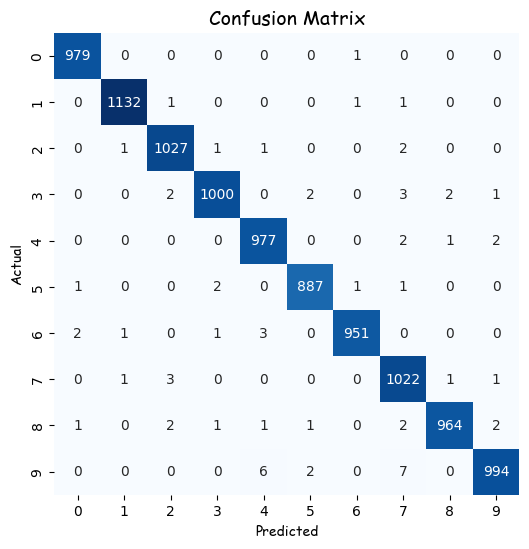

In [39]:
# Confusion matrix
test_nn = test_dig.to(device)
tlabel_nn = test_lab.to(device)

## Loading the model from the best epoch
model_best = baseNeuralNetworkfinDA().to(device)
model_best.load_state_dict(torch.load('best_model.pt'))
model_best.eval()
test_logits = model_best(test_nn).squeeze()
test_pred = torch.argmax(soft(test_logits),axis=1)
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=tlabel_nn.detach().cpu().numpy(),y_pred=test_pred.detach().cpu().numpy())
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, 
            cbar=False,fmt='1d', cmap='Blues', ax=ax)
bigfont = {'family': 'Comic Sans MS',
        'color':  'black',
        'weight': 'normal',
        'size': 14,
        }
font = {'family': 'Comic Sans MS',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
        }
ax.set_title('Confusion Matrix',bigfont)
ax.set_xlabel('Predicted',font)
ax.set_ylabel('Actual',font)
plt.show()

Thus we got a accuracy of
* Without data augmentation -- 98.13 %
*  With data augmentation -- 99.33 %
